# Simulated Dyadic IBI Data

We generate three synthetic dyad recordings to demonstrate coupling, leader–follower dynamics,
and non-coupling in wx.
All simulated signals are derived from a real IBI recording so they retain physiological realism.

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.signal import welch

plt.rcParams.update({
    'figure.dpi': 120,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'font.size': 11,
})

## Source data

We load person A's IBI series from a real recording. This is our **source signal** —
all simulated person-B series will be derived from it, ensuring the base physiology looks real.

In [74]:
def load_ibi(path, clip_ms=(300, 990)):
    """Load IBI series from a Mindware xlsx export (sheet 'IBI Series').
    Row 0 is a segment marker and is skipped. Values outside clip_ms are removed.
    Upper bound kept below 1000 ms to stay within wx's valid range."""
    df = pd.read_excel(path, sheet_name='IBI Series', header=None)
    ibi = df.iloc[1:, 0].astype(float).values
    lo, hi = clip_ms
    mask = (ibi >= lo) & (ibi <= hi)
    n_removed = (~mask).sum()
    if n_removed:
        print(f'  {path}: removed {n_removed} outlier(s) outside [{lo}, {hi}] ms')
    return ibi[mask]

ibi_a = load_ibi('dyad_recording/HRV_a.xlsx')
ibi_b_real = load_ibi('dyad_recording/HRV_b.xlsx')   # kept for reference / condition 3

MEAN_B = ibi_b_real.mean()   # target mean HR for simulated person B (~644 ms, ~93 bpm)

for name, ibi in [('A (source)', ibi_a), ('B (real, reference)', ibi_b_real)]:
    dur = ibi.sum() / 1000
    print(f'Person {name}: n={len(ibi):4d}  mean={ibi.mean():.1f} ms '
          f'({60000/ibi.mean():.1f} bpm)  SD={ibi.std():.1f} ms  '
          f'duration={dur:.0f} s ({dur/60:.1f} min)')

  dyad_recording/HRV_a.xlsx: removed 5 outlier(s) outside [300, 990] ms
  dyad_recording/HRV_b.xlsx: removed 1 outlier(s) outside [300, 990] ms
Person A (source): n= 539  mean=816.5 ms (73.5 bpm)  SD=84.1 ms  duration=440 s (7.3 min)
Person B (real, reference): n= 846  mean=644.7 ms (93.1 bpm)  SD=44.5 ms  duration=545 s (9.1 min)


---
## Condition 1 — Drifting Coupling

In this condition the two people start uncoupled, gradually synchronise in the middle of
the recording, and then drift apart again. In the wx heatmap this should appear as a
bright band centred on lag 0 that emerges and fades over time.

**Pipeline:**
1. Resample person A's IBI series to a uniform 5 Hz grid (matching wx).
2. Generate an independent noise signal with the exact same power spectrum via phase randomisation.
3. Mix A's signal and the noise according to a smooth coupling envelope α(t).
4. Add a different mean HR so person B looks like a distinct individual.
5. Convert the continuous signal back to an event-based IBI series.

In [75]:
# ── Simulation parameters ──────────────────────────────────────────────
FS         = 5      # Hz  — must match wx's resampling rate
ALPHA_MAX  = 0.90   # peak coupling strength  (expected wx r ≈ 0.90 at peak)
SEED       = 42     # fixed seed for reproducibility

### Step 1 — Resample to a uniform grid

IBI series are event-based: each value is the time between two beats, so the samples
are irregularly spaced in time. We use cubic spline interpolation to get a continuous
signal at a fixed 5 Hz rate — the same step wx performs internally.

In [76]:
def ibi_to_uniform(ibi_ms, fs=5):
    """Resample event-based IBI series to a uniform time grid via cubic spline.
    Returns (time_seconds, ibi_values_ms)."""
    ibi = np.asarray(ibi_ms, dtype=float)
    t_beat_ms = np.cumsum(np.insert(ibi, 0, 0)[:-1])   # beat onset times (ms)
    cs = CubicSpline(t_beat_ms, ibi)
    t_ms = np.arange(t_beat_ms[0], t_beat_ms[-1], 1000 / fs)
    return t_ms / 1000, cs(t_ms)   # seconds, ms

t_a, x_a = ibi_to_uniform(ibi_a, fs=FS)
N = len(x_a)

print(f'Resampled:  {N} samples  |  {t_a[-1]:.1f} s  |  '
      f'mean = {x_a.mean():.1f} ms  |  SD = {x_a.std():.1f} ms')

Resampled:  2197 samples  |  439.2 s  |  mean = 824.9 ms  |  SD = 81.6 ms


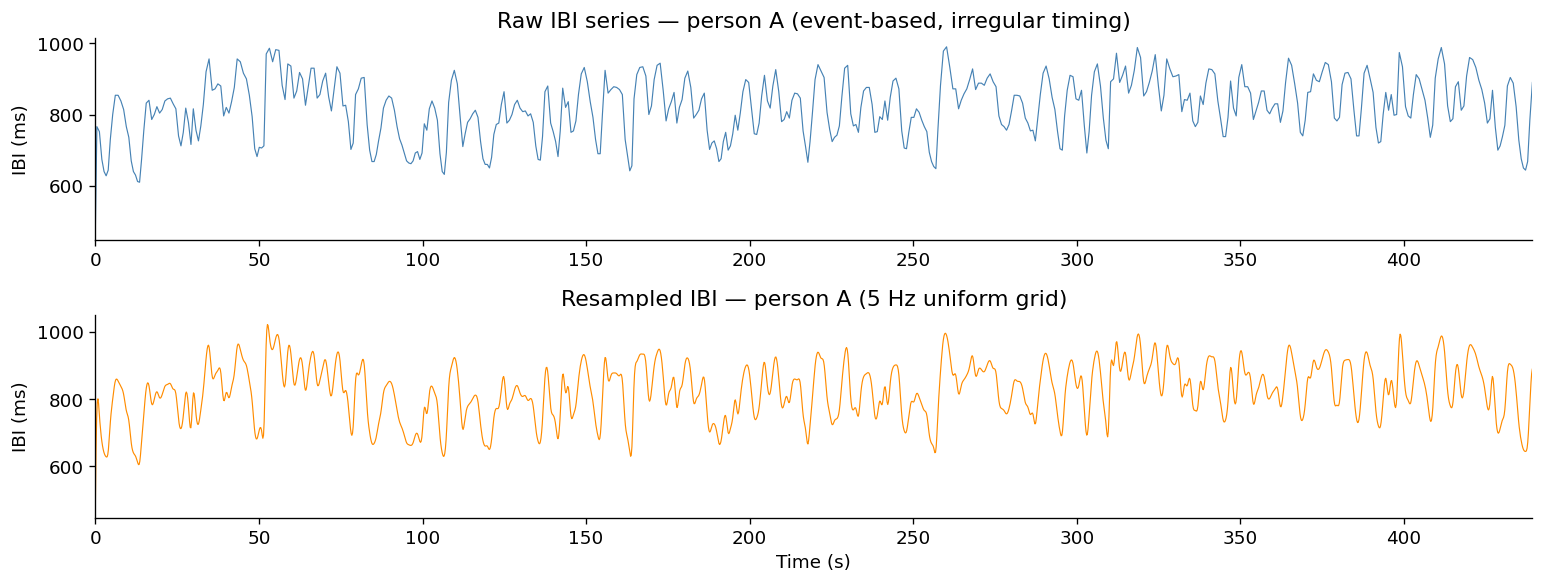

In [77]:
beat_t_a = np.cumsum(np.insert(ibi_a, 0, 0)[:-1]) / 1000   # beat-onset times in seconds

fig, axes = plt.subplots(2, 1, figsize=(13, 5), sharex=False)

axes[0].plot(beat_t_a, ibi_a, lw=0.7, color='steelblue')
axes[0].set_ylabel('IBI (ms)')
axes[0].set_title('Raw IBI series — person A (event-based, irregular timing)')

axes[1].plot(t_a, x_a, lw=0.7, color='darkorange')
axes[1].set_ylabel('IBI (ms)')
axes[1].set_xlabel('Time (s)')
axes[1].set_title(f'Resampled IBI — person A ({FS} Hz uniform grid)')

for ax in axes:
    ax.set_xlim(0, max(beat_t_a[-1], t_a[-1]))

plt.tight_layout()
plt.show()

### Step 2 — Phase-randomised surrogate (independent noise)

We need a noise signal that looks like a real HRV series — with the same 1/f spectral
shape and RSA peak — but is statistically **independent** of person A.

Phase randomisation achieves this: take the FFT of A’s signal, keep all the amplitudes
(which encode the spectrum) but replace every phase with a random angle. The result has
an identical power spectrum but zero cross-correlation with A.

In [78]:
def phase_randomize(signal, seed=None):
    """Generate a phase-randomised surrogate of a zero-mean signal.
    Preserves amplitude spectrum; destroys all temporal structure."""
    rng = np.random.default_rng(seed)
    N = len(signal)
    fft_vals = np.fft.rfft(signal)
    amplitudes = np.abs(fft_vals)
    phases = rng.uniform(0, 2 * np.pi, len(fft_vals))
    phases[0] = 0                       # keep DC phase (zero mean)
    if N % 2 == 0:
        phases[-1] = 0                  # Nyquist must be real
    return np.fft.irfft(amplitudes * np.exp(1j * phases), n=N)

mean_a    = x_a.mean()
x_a_fluct = x_a - mean_a               # zero-mean fluctuation

epsilon = phase_randomize(x_a_fluct, seed=SEED)

r_check = np.corrcoef(x_a_fluct, epsilon)[0, 1]
print(f'Cross-correlation A vs surrogate: r = {r_check:.4f}  (should be ≈ 0)')

Cross-correlation A vs surrogate: r = 0.0217  (should be ≈ 0)


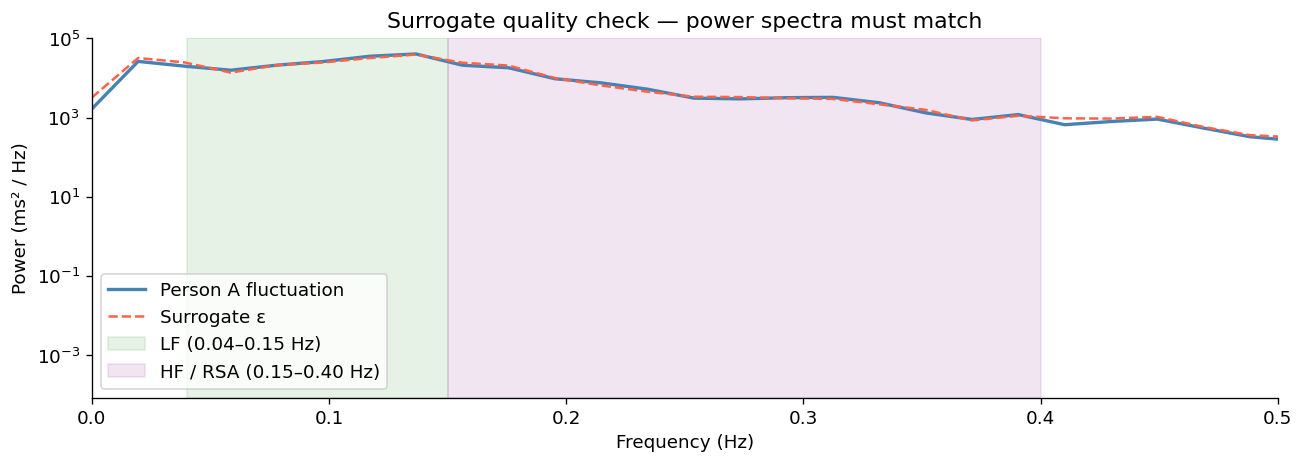

In [79]:
f_a,   p_a   = welch(x_a_fluct, fs=FS, nperseg=256)
f_eps, p_eps = welch(epsilon,    fs=FS, nperseg=256)

fig, ax = plt.subplots(figsize=(11, 4))
ax.semilogy(f_a,   p_a,   lw=2,   color='steelblue', label='Person A fluctuation')
ax.semilogy(f_eps, p_eps, lw=1.5, color='tomato', linestyle='--', label='Surrogate ε')
ax.axvspan(0.04, 0.15, alpha=0.10, color='green',  label='LF (0.04–0.15 Hz)')
ax.axvspan(0.15, 0.40, alpha=0.10, color='purple', label='HF / RSA (0.15–0.40 Hz)')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (ms² / Hz)')
ax.set_xlim(0, 0.5)
ax.set_title('Surrogate quality check — power spectra must match')
ax.legend()
plt.tight_layout()
plt.show()

#### Why phase randomisation produces independence

Two plots confirm the surrogate has the right properties:

- **Same shape, different trajectory** (time domain): the surrogate and person A have nearly
  identical amplitude and texture — they could both pass for real HRV — but their moment-to-moment
  values are unrelated.
- **Zero cross-correlation at all lags**: the grey band shows the range you would expect from
  100 independent phase-randomised surrogates. Our ε falls squarely within it at every lag.
  The band is wider than the naive `±1.96/√N` formula because HRV has a 1/f spectrum — the
  slow fluctuations create long-range autocorrelation that inflates the variance of any
  lag-by-lag estimate. The bootstrap handles this automatically.

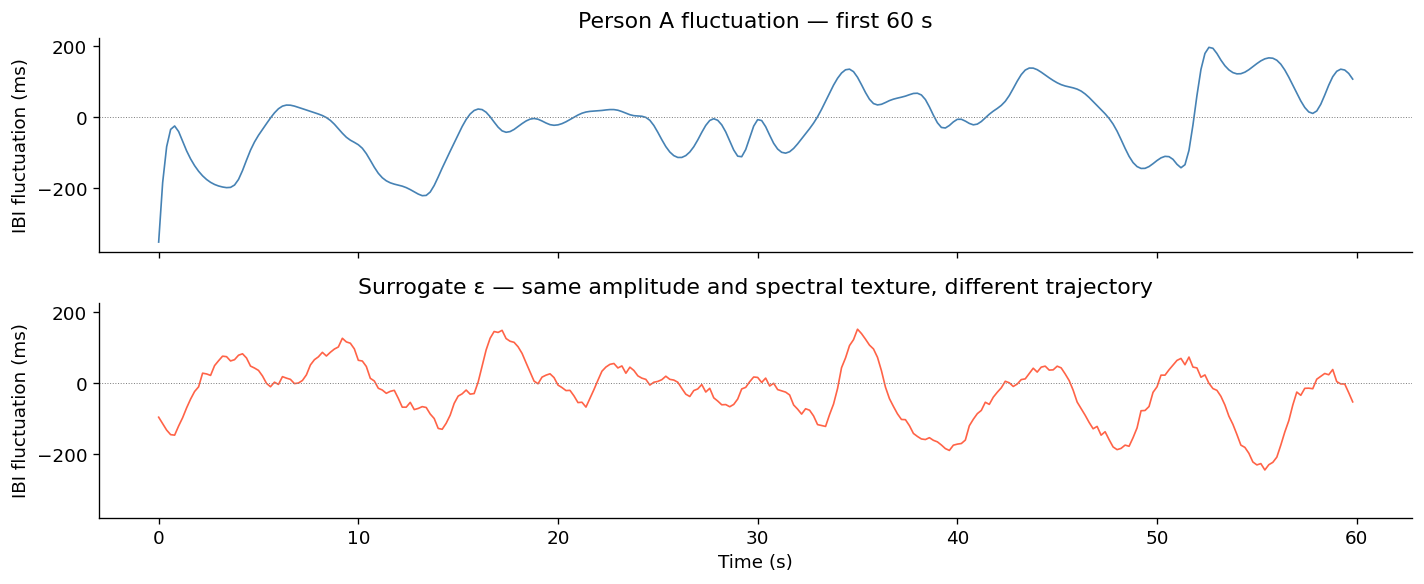

In [80]:
SHOW_S = 60
show_n = int(SHOW_S * FS)

fig, axes = plt.subplots(2, 1, figsize=(12, 5), sharex=True, sharey=True)

axes[0].plot(t_a[:show_n], x_a_fluct[:show_n], lw=1.0, color='steelblue')
axes[0].axhline(0, color='gray', lw=0.6, linestyle=':')
axes[0].set_ylabel('IBI fluctuation (ms)')
axes[0].set_title('Person A fluctuation — first 60 s')

axes[1].plot(t_a[:show_n], epsilon[:show_n], lw=1.0, color='tomato')
axes[1].axhline(0, color='gray', lw=0.6, linestyle=':')
axes[1].set_ylabel('IBI fluctuation (ms)')
axes[1].set_xlabel('Time (s)')
axes[1].set_title('Surrogate ε — same amplitude and spectral texture, different trajectory')

plt.tight_layout()
plt.show()

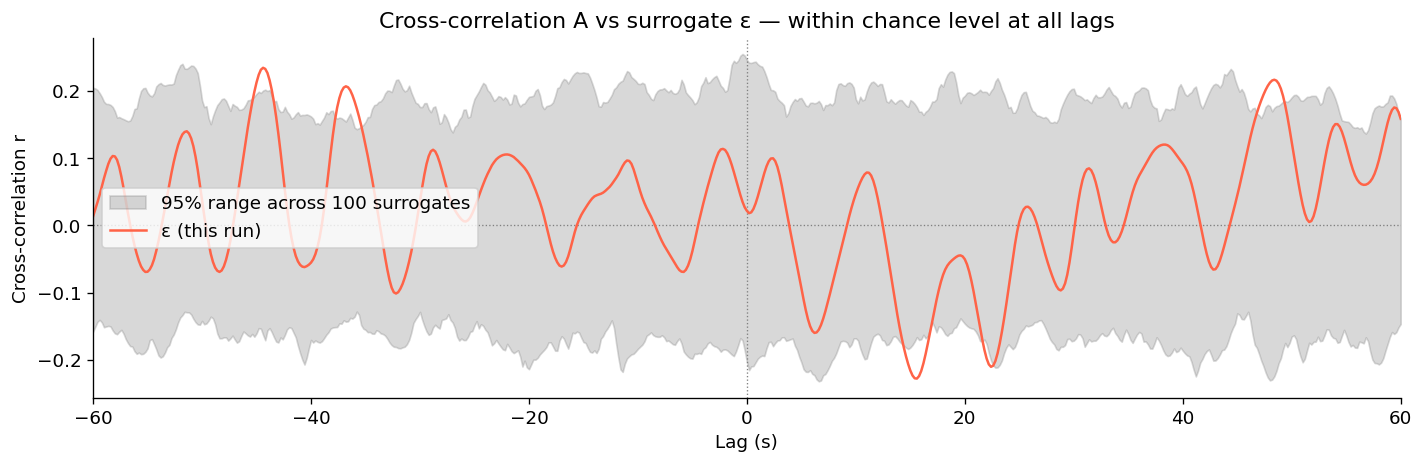

Max |r| for ε: 0.234  |  95% CI width at lag=0: ±0.246


In [81]:
from scipy.signal import correlate

MAX_LAG_S = 60
max_lag_n = int(MAX_LAG_S * FS)

xa_z  = (x_a_fluct - x_a_fluct.mean()) / x_a_fluct.std()
eps_z = (epsilon    - epsilon.mean())   / epsilon.std()

# Cross-correlation of the actual surrogate with A
cc        = correlate(xa_z, eps_z, mode='full') / N
lags_full = np.arange(-(N - 1), N) / FS
mid       = N - 1
cc_trim   = cc[mid - max_lag_n : mid + max_lag_n + 1]
lags_trim = lags_full[mid - max_lag_n : mid + max_lag_n + 1]

# Bootstrap envelope: 100 independent surrogates show what "chance" looks like.
# The naive ±1.96/√N CI is too narrow for 1/f signals (long-range autocorrelation
# inflates the sampling variance). The bootstrap captures this correctly.
rng_boot = np.random.default_rng(0)
cc_boot  = np.zeros((100, len(cc_trim)))
for i in range(100):
    eps_i   = phase_randomize(x_a_fluct, seed=int(rng_boot.integers(1_000_000)))
    eps_i_z = (eps_i - eps_i.mean()) / eps_i.std()
    cc_i    = correlate(xa_z, eps_i_z, mode='full') / N
    cc_boot[i] = cc_i[mid - max_lag_n : mid + max_lag_n + 1]

ci_lo = np.percentile(cc_boot, 2.5,  axis=0)
ci_hi = np.percentile(cc_boot, 97.5, axis=0)

fig, ax = plt.subplots(figsize=(12, 4))
ax.fill_between(lags_trim, ci_lo, ci_hi, alpha=0.30, color='gray',
                label='95% range across 100 surrogates')
ax.axhline(0, color='gray', lw=0.8, linestyle=':')
ax.axvline(0, color='gray', lw=0.8, linestyle=':')
ax.plot(lags_trim, cc_trim, lw=1.5, color='tomato', label='ε (this run)')
ax.set_xlabel('Lag (s)')
ax.set_ylabel('Cross-correlation r')
ax.set_xlim(-MAX_LAG_S, MAX_LAG_S)
ax.set_title('Cross-correlation A vs surrogate ε — within chance level at all lags')
ax.legend()
plt.tight_layout()
plt.show()

print(f'Max |r| for ε: {np.max(np.abs(cc_trim)):.3f}  '
      f'|  95% CI width at lag=0: ±{max(abs(ci_lo[max_lag_n]), ci_hi[max_lag_n]):.3f}')

### Step 3 — Coupling envelope and mixing model

We control coupling strength with a time-varying weight α(t) ∈ [0, 1].
A Hanning window centred on the middle of the recording gives a smooth
onset and offset — no abrupt switches.

The mixed signal is:

> **B(t) = α(t) · A(t) + √(1 − α²(t)) · ε(t)**

The √(1 − α²) term keeps the variance of B constant regardless of α —
so the signal looks equally ‘active’ whether it is coupled or not.
When α = 0.9 at the peak, the expected Pearson r between A and B is 0.9.

Coupling active:  73 s → 366 s  (67% of recording, peak at 220 s)


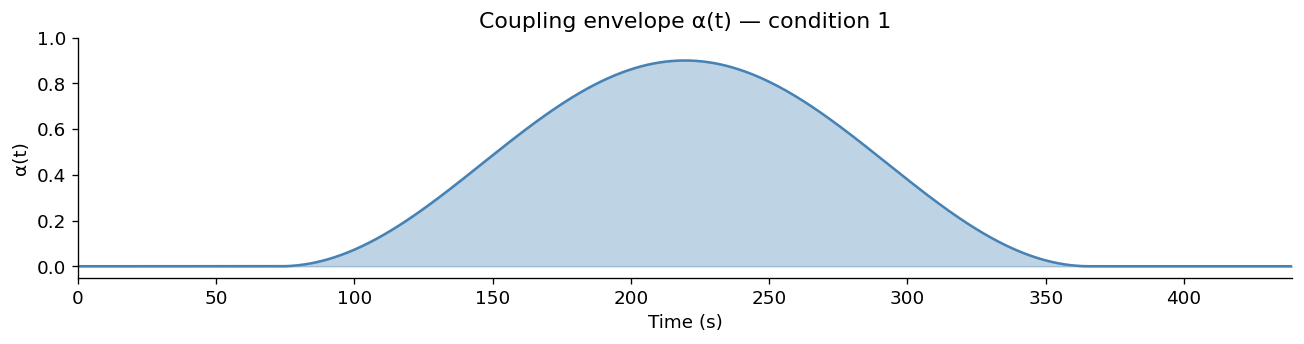

In [82]:
t_on  = N // 6
t_off = 5 * N // 6
win_len = t_off - t_on

alpha = np.zeros(N)
alpha[t_on:t_off] = np.hanning(win_len)
alpha *= ALPHA_MAX

print(f'Coupling active:  {t_a[t_on]:.0f} s → {t_a[t_off-1]:.0f} s  '
      f'({(t_off - t_on) / N * 100:.0f}% of recording, '
      f'peak at {t_a[(t_on + t_off)//2]:.0f} s)')

fig, ax = plt.subplots(figsize=(11, 3))
ax.fill_between(t_a, alpha, alpha=0.35, color='steelblue')
ax.plot(t_a, alpha, lw=1.5, color='steelblue')
ax.set_xlabel('Time (s)')
ax.set_ylabel('α(t)')
ax.set_ylim(-0.05, 1.0)
ax.set_xlim(0, t_a[-1])
ax.set_title('Coupling envelope α(t) — condition 1')
plt.tight_layout()
plt.show()

In [83]:
x_b_fluct = alpha * x_a_fluct + np.sqrt(1 - alpha**2) * epsilon

x_b = x_b_fluct + MEAN_B
x_b = np.clip(x_b, 300, 990)   # stay within wx's valid range [100, 1000)

print(f'Person A:  mean = {x_a.mean():.1f} ms  ({60000/x_a.mean():.1f} bpm)  SD = {x_a.std():.1f} ms')
print(f'Person B:  mean = {x_b.mean():.1f} ms  ({60000/x_b.mean():.1f} bpm)  SD = {x_b.std():.1f} ms')

Person A:  mean = 824.9 ms  (72.7 bpm)  SD = 81.6 ms
Person B:  mean = 640.2 ms  (93.7 bpm)  SD = 83.8 ms


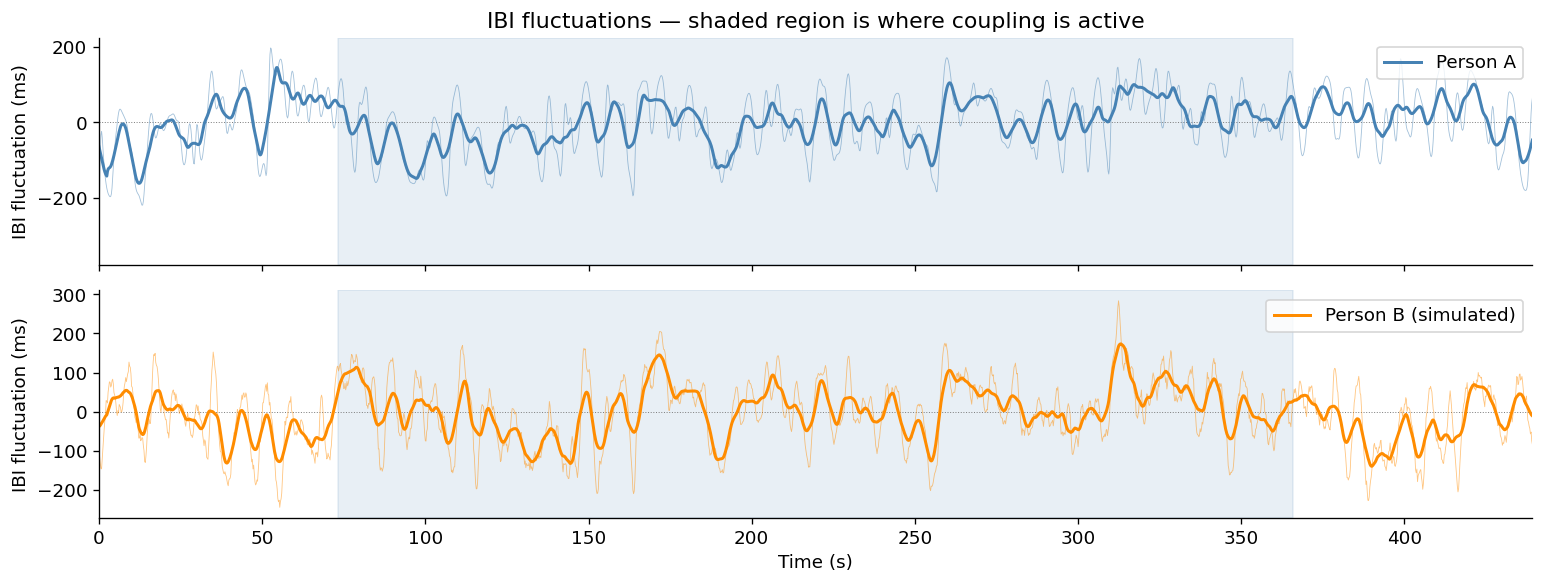

In [84]:
def smooth(x, sec=5, fs=FS):
    k = int(sec * fs)
    return np.convolve(x, np.ones(k) / k, mode='same')

t_on_s  = t_a[t_on]
t_off_s = t_a[t_off - 1]

fig, axes = plt.subplots(2, 1, figsize=(13, 5), sharex=True)

for ax in axes:
    ax.axvspan(t_on_s, t_off_s, alpha=0.12, color='steelblue', zorder=0)
    ax.axhline(0, color='gray', lw=0.6, linestyle=':')

axes[0].plot(t_a, x_a_fluct, lw=0.5, color='steelblue', alpha=0.5)
axes[0].plot(t_a, smooth(x_a_fluct), lw=1.8, color='steelblue', label='Person A')
axes[0].set_ylabel('IBI fluctuation (ms)')
axes[0].set_title('IBI fluctuations — shaded region is where coupling is active')
axes[0].legend(loc='upper right')

axes[1].plot(t_a, x_b_fluct, lw=0.5, color='darkorange', alpha=0.5)
axes[1].plot(t_a, smooth(x_b_fluct), lw=1.8, color='darkorange', label='Person B (simulated)')
axes[1].set_ylabel('IBI fluctuation (ms)')
axes[1].set_xlabel('Time (s)')
axes[1].legend(loc='upper right')

for ax in axes:
    ax.set_xlim(0, t_a[-1])

plt.tight_layout()
plt.show()

### Step 4 — Rolling correlation preview

This is a simplified version of what wx will show at lag = 0.
We compute Pearson r in a sliding 60-second window and plot it against
the coupling envelope. The two should track each other closely.

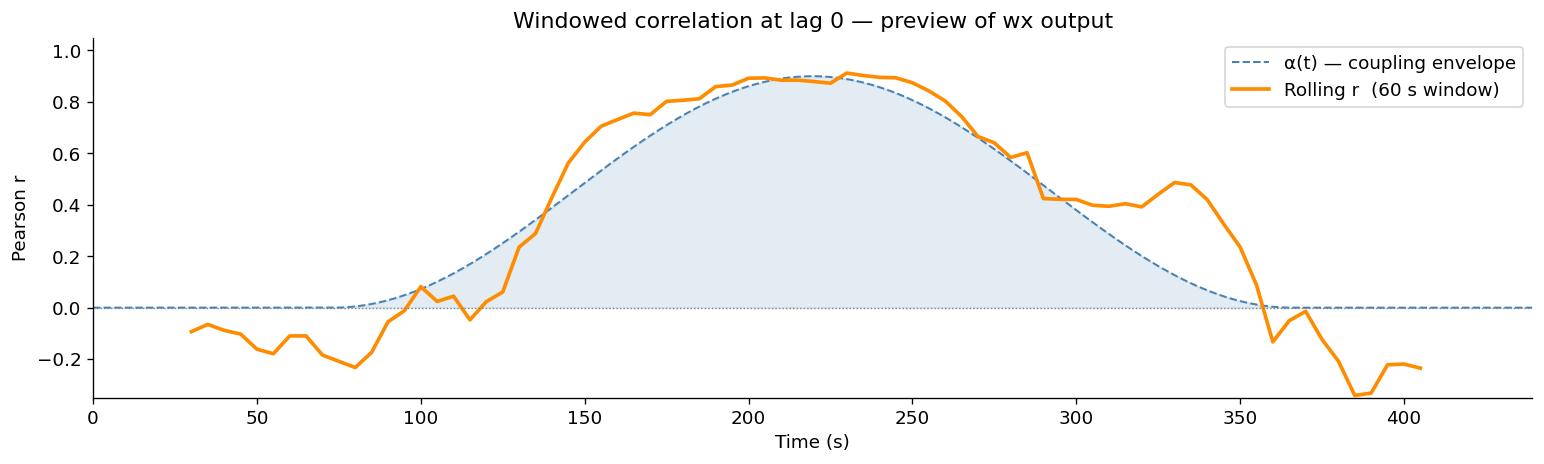

Peak rolling r = 0.91  |  mean r in uncoupled regions = -0.12


In [85]:
WIN_S  = 60
STEP_S = 5
win_n  = int(WIN_S  * FS)
step_n = int(STEP_S * FS)

centers, rs = [], []
for start in range(0, N - win_n, step_n):
    end = start + win_n
    r = np.corrcoef(x_a_fluct[start:end], x_b_fluct[start:end])[0, 1]
    centers.append(t_a[start + win_n // 2])
    rs.append(r)

centers = np.array(centers)
rs      = np.array(rs)

fig, ax = plt.subplots(figsize=(13, 4))
ax.fill_between(t_a, alpha, alpha=0.15, color='steelblue')
ax.plot(t_a, alpha, lw=1.2, color='steelblue', linestyle='--', label='α(t) — coupling envelope')
ax.plot(centers, rs, lw=2.2, color='darkorange', label=f'Rolling r  ({WIN_S} s window)')
ax.axhline(0, color='gray', lw=0.8, linestyle=':')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Pearson r')
ax.set_ylim(-0.35, 1.05)
ax.set_xlim(0, t_a[-1])
ax.set_title('Windowed correlation at lag 0 — preview of wx output')
ax.legend()
plt.tight_layout()
plt.show()

print(f'Peak rolling r = {rs.max():.2f}  |  '
      f'mean r in uncoupled regions = {np.mean(rs[centers < t_on_s]):.2f}')

### Step 5 — Convert back to event-based IBIs

wx expects an event-based IBI series as input.
We recover beat times from the continuous signal by stepping forward iteratively:
the IBI at the current beat gives the time to the next beat.
This is a simple and fully invertible transformation.

In [86]:
def uniform_to_ibi(t_sec, x_ms, clip_ms=(300, 990)):
    """Convert a uniformly-sampled IBI signal back to an event-based IBI series.
    Iteratively steps forward: next_beat = current_beat + IBI(current_beat) / 1000."""
    cs = CubicSpline(t_sec, x_ms)
    t_max = t_sec[-1]
    lo, hi = clip_ms

    beat_times = [float(t_sec[0])]
    while True:
        t_curr = beat_times[-1]
        ibi_ms = float(np.clip(cs(t_curr), lo, hi))
        t_next = t_curr + ibi_ms / 1000
        if t_next >= t_max:
            break
        beat_times.append(t_next)

    return (np.diff(beat_times) * 1000).astype(float)   # ms

ibi_b_c1 = uniform_to_ibi(t_a, x_b)

dur_b = ibi_b_c1.sum() / 1000
print(f'Person B (event-based):  n = {len(ibi_b_c1)} beats  '
      f'| mean = {ibi_b_c1.mean():.1f} ms  '
      f'| SD = {ibi_b_c1.std():.1f} ms  '
      f'| duration = {dur_b:.0f} s ({dur_b/60:.1f} min)')
print(f'Person A (event-based):  n = {len(ibi_a)} beats  '
      f'| mean = {ibi_a.mean():.1f} ms  '
      f'| SD = {ibi_a.std():.1f} ms')

Person B (event-based):  n = 697 beats  | mean = 629.3 ms  | SD = 85.4 ms  | duration = 439 s (7.3 min)
Person A (event-based):  n = 539 beats  | mean = 816.5 ms  | SD = 84.1 ms


### Step 6 — Save

Each condition is saved using a pair of simple xlsx files.

In [87]:
import os

def save_condition(ibi_a_out, ibi_b_out, dirname):
    """Save a dyad as a subfolder of dyads_simulated/ with one xlsx per person.
    Format: header row, then [t_offset=0, ibi_1, ..., ibi_n].
    wx reads signal[0] as t_offset_ms and signal[1:-1] as the actual IBIs."""
    folder = f'dyads_simulated/{dirname}'
    os.makedirs(folder, exist_ok=True)
    for label, ibi in [('HRV_A', ibi_a_out), ('HRV_B', ibi_b_out)]:
        data = np.concatenate([[0.0], ibi.astype(float)])
        pd.DataFrame({'IBI_ms': data}).to_excel(
            f'{folder}/{label}.xlsx', index=False, sheet_name='IBI Series')
        print(f'Saved → {folder}/{label}.xlsx  ({len(ibi)} beats)')

save_condition(ibi_a, ibi_b_c1, 'cond1_drifting_coupling')

Saved → dyads_simulated/cond1_drifting_coupling/HRV_A.xlsx  (539 beats)
Saved → dyads_simulated/cond1_drifting_coupling/HRV_B.xlsx  (697 beats)


---
## Condition 2 — Leader-follower

In this condition person A consistently leads person B by a fixed time lag τ,
but the coupling itself emerges and disappears over the same segment as in condition 1.
In the wx heatmap this should appear as a bright band that appears and fades
at a constant positive lag offset from the diagonal.

The mixing model uses the same Hanning envelope α(t) as condition 1, but
person A's signal is shifted by τ before mixing:

> **B(t) = α(t) · A(t − τ) + √(1 − α²(t)) · ε(t)**

Outside the coupling window α = 0, so B is pure independent noise — identical to condition 3.
Inside the window the lag-shifted A signal bleeds in with strength α(t).

In [88]:
LAG_S = 4.0               # A leads B by this many seconds
LAG_N = int(LAG_S * FS)  # same lag in samples (4 s × 5 Hz = 20 samples)

# Shift A forward by LAG_N samples: x_a_lagged[t] = x_a_fluct[t - LAG_N]
x_a_lagged = np.zeros(N)
x_a_lagged[LAG_N:] = x_a_fluct[:N - LAG_N]

# Same Hanning envelope as condition 1 — coupling active for the middle segment only
x_b_fluct_c2 = alpha * x_a_lagged + np.sqrt(1 - alpha**2) * epsilon
x_b_c2 = np.clip(x_b_fluct_c2 + MEAN_B, 300, 990)

print(f'Lag:      {LAG_S:.0f} s  ({LAG_N} samples at {FS} Hz)')
print(f'Coupling: {t_a[t_on]:.0f} s → {t_a[t_off-1]:.0f} s  (same window as condition 1)')
print(f'Person A: mean = {x_a.mean():.1f} ms  ({60000/x_a.mean():.1f} bpm)  SD = {x_a.std():.1f} ms')
print(f'Person B: mean = {x_b_c2.mean():.1f} ms  ({60000/x_b_c2.mean():.1f} bpm)  SD = {x_b_c2.std():.1f} ms')

Lag:      4 s  (20 samples at 5 Hz)
Coupling: 73 s → 366 s  (same window as condition 1)
Person A: mean = 824.9 ms  (72.7 bpm)  SD = 81.6 ms
Person B: mean = 639.8 ms  (93.8 bpm)  SD = 83.6 ms


### Signal comparison — the lag in the time domain

Zooming into the middle segment (where coupling is active) makes the lag visible by eye:
person B's fluctuations are a shifted copy of person A's, offset by τ seconds to the right.
Before and after the shaded window the two signals are unrelated.

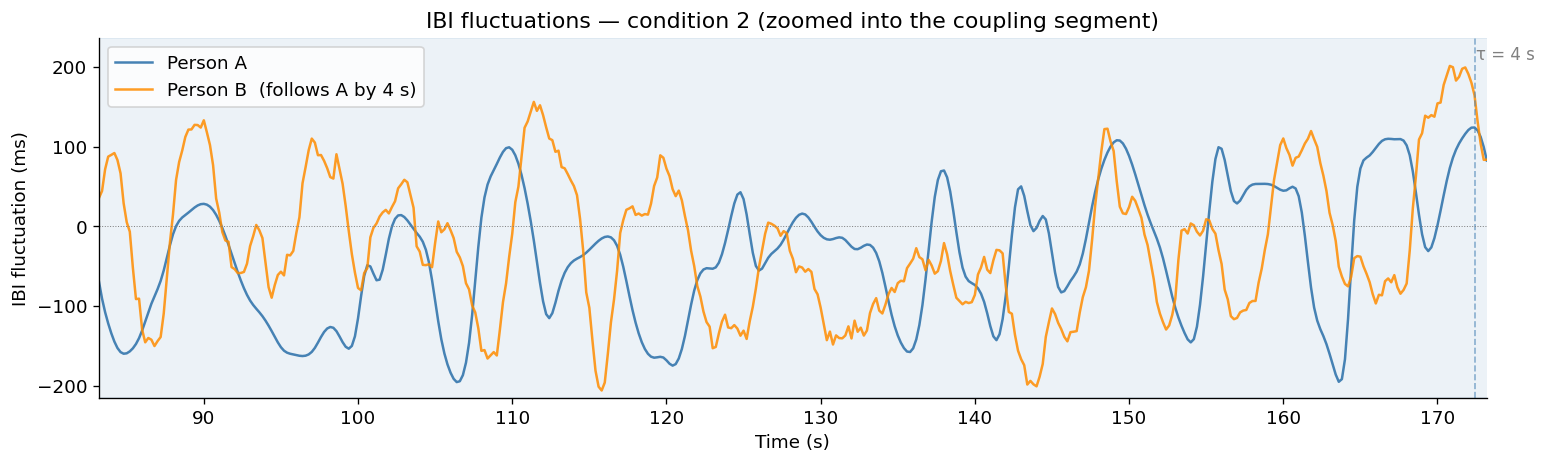

In [89]:
# Zoom into the active coupling segment
ZOOM_START = t_on_s + 10   # just inside the window so coupling is already non-zero
ZOOM_END   = ZOOM_START + 90

mask = (t_a >= ZOOM_START) & (t_a <= ZOOM_END)
t_zoom = t_a[mask]

ymax = np.max(np.abs(x_a_fluct[mask])) * 1.1

fig, ax = plt.subplots(figsize=(13, 4))
ax.axvspan(t_on_s, t_off_s, alpha=0.10, color='steelblue', zorder=0)
ax.plot(t_zoom, x_a_fluct[mask],    lw=1.5, color='steelblue',  label='Person A')
ax.plot(t_zoom, x_b_fluct_c2[mask], lw=1.5, color='darkorange',
        label=f'Person B  (follows A by {LAG_S:.0f} s)', alpha=0.85)

# mark the highest peak in A and its echo in B
peak_t = t_zoom[np.argmax(x_a_fluct[mask])]
ax.axvline(peak_t,         color='steelblue',  lw=1.0, linestyle='--', alpha=0.6)
ax.axvline(peak_t + LAG_S, color='darkorange', lw=1.0, linestyle='--', alpha=0.6)
ax.annotate('', xy=(peak_t + LAG_S, ymax * 0.92), xytext=(peak_t, ymax * 0.92),
            arrowprops=dict(arrowstyle='<->', color='gray', lw=1.5))
ax.text(peak_t + LAG_S / 2, ymax * 0.97,
        f'τ = {LAG_S:.0f} s', ha='center', color='gray', fontsize=10)

ax.axhline(0, color='gray', lw=0.6, linestyle=':')
ax.set_xlabel('Time (s)')
ax.set_ylabel('IBI fluctuation (ms)')
ax.set_xlim(ZOOM_START, ZOOM_END)
ax.set_ylim(-ymax, ymax * 1.1)
ax.set_title('IBI fluctuations — condition 2 (zoomed into the coupling segment)')
ax.legend()
plt.tight_layout()
plt.show()

### Rolling correlation at lag τ — preview of wx output

The direct analog of condition 1's lag-0 rolling correlation, but now evaluated
at the expected leader-follower lag: we slide a 60-second window and compute
r(A[window], B[window + τ]).

When coupling is active this should track α(t). Outside the coupling window it
drops back to near zero — same as the lag-0 value would be throughout condition 3.

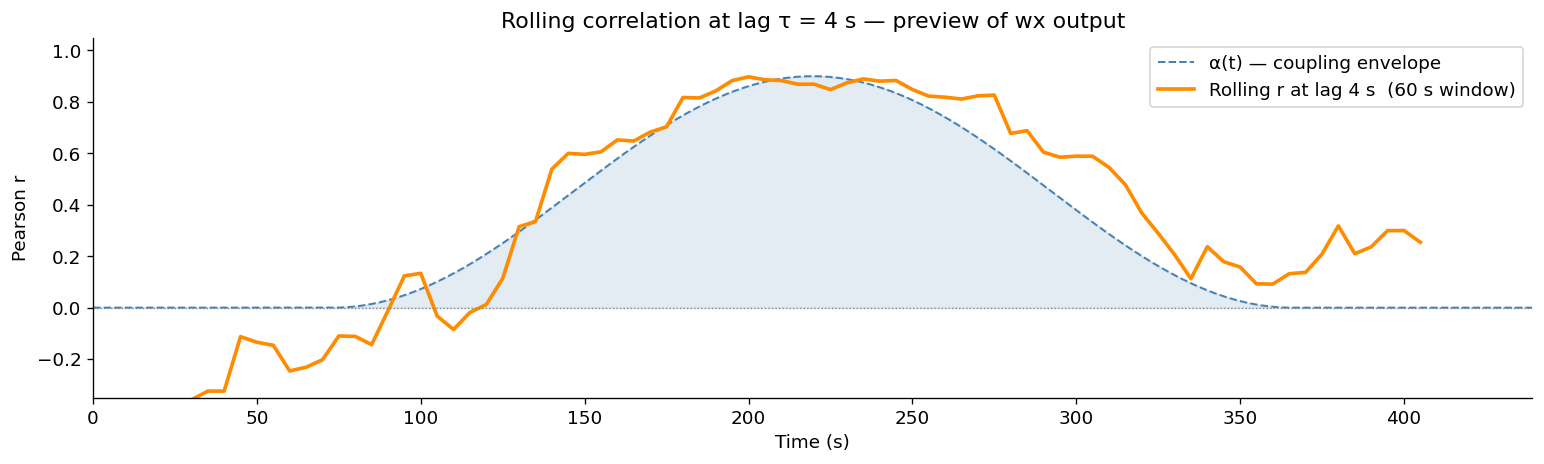

Peak rolling r at τ = 0.90  |  mean r outside coupling = -0.23


In [90]:
centers_c2, rs_c2 = [], []
for start in range(0, N - win_n - LAG_N, step_n):
    end = start + win_n
    # shift B forward by LAG_N so we evaluate at lag = +LAG_S
    r = np.corrcoef(x_a_fluct[start:end],
                    x_b_fluct_c2[start + LAG_N : end + LAG_N])[0, 1]
    centers_c2.append(t_a[start + win_n // 2])
    rs_c2.append(r)
centers_c2 = np.array(centers_c2)
rs_c2      = np.array(rs_c2)

fig, ax = plt.subplots(figsize=(13, 4))
ax.fill_between(t_a, alpha, alpha=0.15, color='steelblue')
ax.plot(t_a, alpha, lw=1.2, color='steelblue', linestyle='--',
        label='α(t) — coupling envelope')
ax.plot(centers_c2, rs_c2, lw=2.2, color='darkorange',
        label=f'Rolling r at lag {LAG_S:.0f} s  ({WIN_S} s window)')
ax.axhline(0, color='gray', lw=0.8, linestyle=':')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Pearson r')
ax.set_ylim(-0.35, 1.05)
ax.set_xlim(0, t_a[-1])
ax.set_title(f'Rolling correlation at lag τ = {LAG_S:.0f} s — preview of wx output')
ax.legend()
plt.tight_layout()
plt.show()

print(f'Peak rolling r at τ = {rs_c2.max():.2f}  |  '
      f'mean r outside coupling = {np.mean(rs_c2[centers_c2 < t_on_s]):.2f}')

In [91]:
ibi_b_c2 = uniform_to_ibi(t_a, x_b_c2)

dur_b2 = ibi_b_c2.sum() / 1000
print(f'Person B (event-based):  n = {len(ibi_b_c2)} beats  '
      f'| mean = {ibi_b_c2.mean():.1f} ms  '
      f'| SD = {ibi_b_c2.std():.1f} ms  '
      f'| duration = {dur_b2:.0f} s ({dur_b2/60:.1f} min)')

save_condition(ibi_a, ibi_b_c2, 'cond2_leader_follower')

Person B (event-based):  n = 698 beats  | mean = 628.7 ms  | SD = 84.8 ms  | duration = 439 s (7.3 min)
Saved → dyads_simulated/cond2_leader_follower/HRV_A.xlsx  (539 beats)
Saved → dyads_simulated/cond2_leader_follower/HRV_B.xlsx  (698 beats)


---
## Condition 3 — No Coupling

In this condition the two people are completely independent.
Person B is a fresh phase-randomised surrogate of A — same spectral shape,
but generated with a different random seed so it has no relationship to A or to the
surrogate used in conditions 1 and 2.

Setting α = 0 collapses the mixing model to B(t) = ε(t), pure independent noise.
In the wx heatmap this should appear as a uniformly dim, noisy surface at all lags
and all time windows — the null baseline.

In [92]:
epsilon_c3   = phase_randomize(x_a_fluct, seed=SEED + 1)   # independent of epsilon (conds 1&2)
x_b_fluct_c3 = epsilon_c3.copy()                           # α = 0 → pure noise
x_b_c3       = np.clip(x_b_fluct_c3 + MEAN_B, 300, 990)

r_c3 = np.corrcoef(x_a_fluct, x_b_fluct_c3)[0, 1]
print(f'Person A: mean = {x_a.mean():.1f} ms  ({60000/x_a.mean():.1f} bpm)  SD = {x_a.std():.1f} ms')
print(f'Person B: mean = {x_b_c3.mean():.1f} ms  ({60000/x_b_c3.mean():.1f} bpm)  SD = {x_b_c3.std():.1f} ms')
print(f'Global r (A vs B): {r_c3:.4f}  (expected ≈ 0)')

Person A: mean = 824.9 ms  (72.7 bpm)  SD = 81.6 ms
Person B: mean = 644.7 ms  (93.1 bpm)  SD = 81.6 ms
Global r (A vs B): 0.2428  (expected ≈ 0)


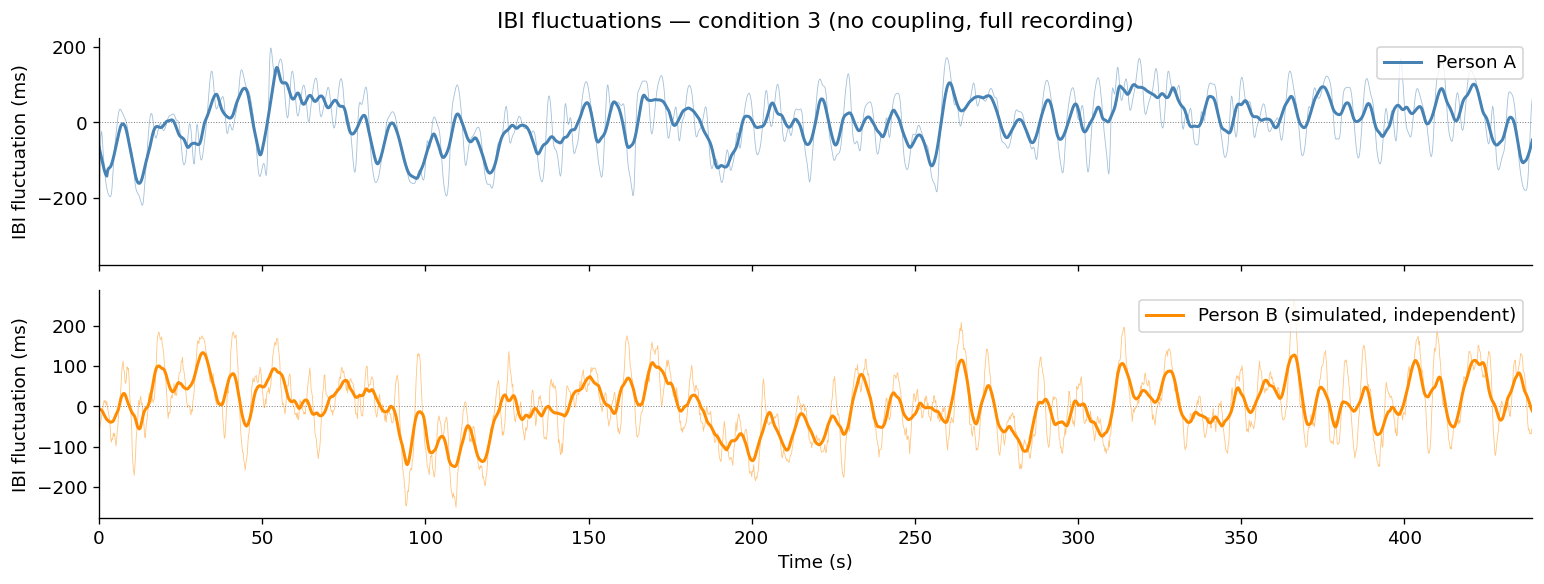

In [93]:
fig, axes = plt.subplots(2, 1, figsize=(13, 5), sharex=True)

for ax in axes:
    ax.axhline(0, color='gray', lw=0.6, linestyle=':')

axes[0].plot(t_a, x_a_fluct,    lw=0.5, color='steelblue',  alpha=0.5)
axes[0].plot(t_a, smooth(x_a_fluct), lw=1.8, color='steelblue',  label='Person A')
axes[0].set_ylabel('IBI fluctuation (ms)')
axes[0].set_title('IBI fluctuations — condition 3 (no coupling, full recording)')
axes[0].legend(loc='upper right')

axes[1].plot(t_a, x_b_fluct_c3, lw=0.5, color='darkorange', alpha=0.5)
axes[1].plot(t_a, smooth(x_b_fluct_c3), lw=1.8, color='darkorange', label='Person B (simulated, independent)')
axes[1].set_ylabel('IBI fluctuation (ms)')
axes[1].set_xlabel('Time (s)')
axes[1].legend(loc='upper right')

for ax in axes:
    ax.set_xlim(0, t_a[-1])

plt.tight_layout()
plt.show()

### Cross-correlation and rolling correlation preview

Two complementary views of independence:

- **Cross-correlation** (full recording, all lags): should be flat and within the bootstrap
  CI from the phase-randomisation check — same null distribution, different realisation.
- **Rolling correlation at lag 0**: should hover near zero throughout, with no systematic
  rise or fall — in contrast to the wave pattern in condition 1.

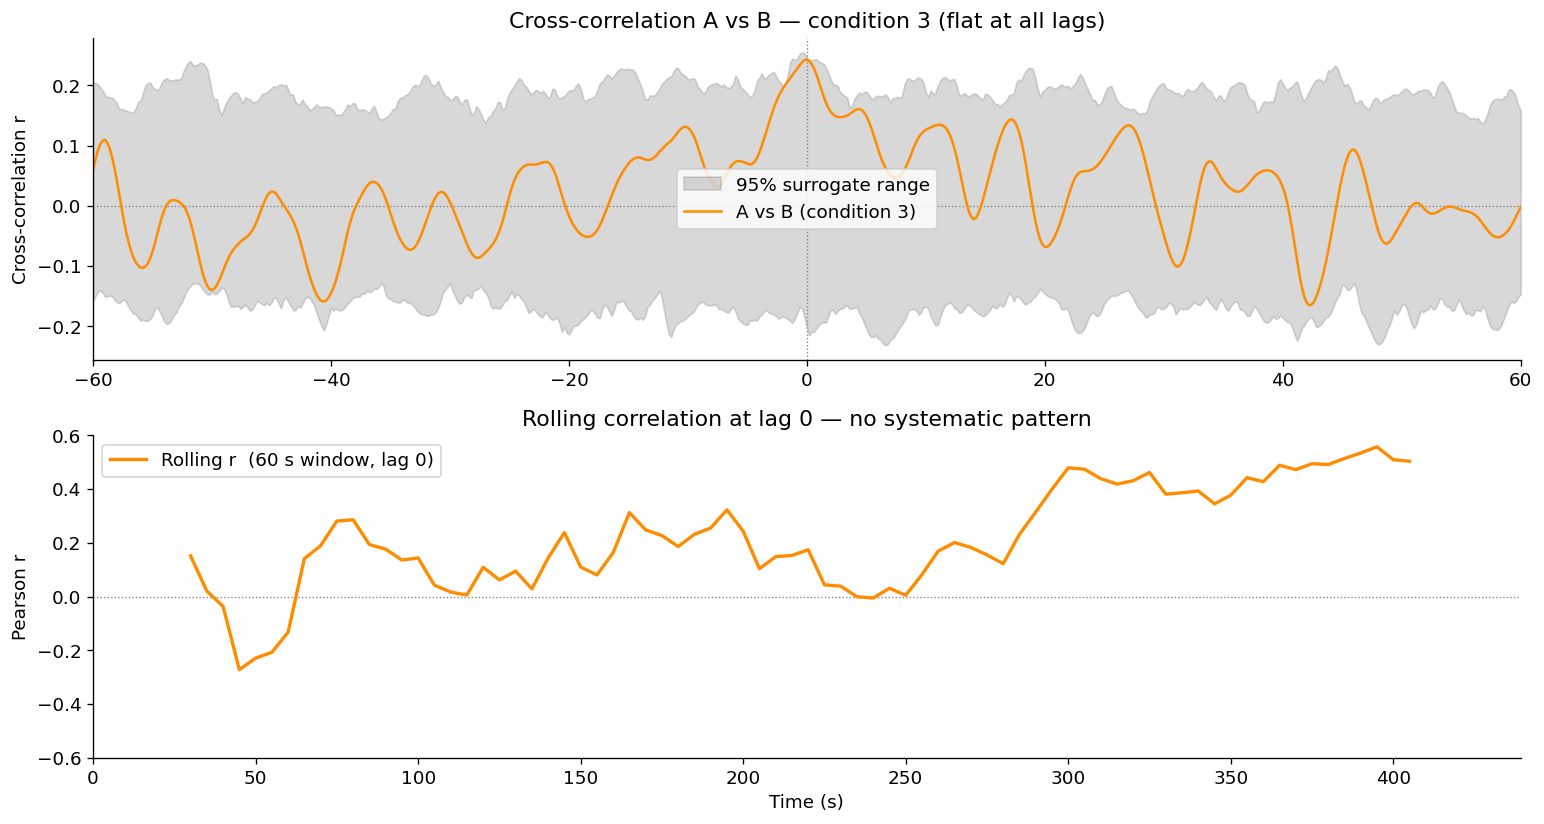

Mean rolling r = 0.217  |  SD = 0.192


In [94]:
# ── Cross-correlation at all lags ──────────────────────────────────────
xa_z3 = (x_a_fluct    - x_a_fluct.mean())    / x_a_fluct.std()
xb_z3 = (x_b_fluct_c3 - x_b_fluct_c3.mean()) / x_b_fluct_c3.std()

cc_c3      = correlate(xa_z3, xb_z3, mode='full') / N
cc_c3_trim = cc_c3[mid - max_lag_n : mid + max_lag_n + 1]   # reuse lags_trim, ci_lo, ci_hi from above

fig, axes = plt.subplots(2, 1, figsize=(13, 7))

# top: cross-correlation
axes[0].fill_between(lags_trim, ci_lo, ci_hi, alpha=0.30, color='gray',
                     label='95% surrogate range')
axes[0].axhline(0, color='gray', lw=0.8, linestyle=':')
axes[0].axvline(0, color='gray', lw=0.8, linestyle=':')
axes[0].plot(lags_trim, cc_c3_trim, lw=1.5, color='darkorange', label='A vs B (condition 3)')
axes[0].set_ylabel('Cross-correlation r')
axes[0].set_xlim(-MAX_LAG_S, MAX_LAG_S)
axes[0].set_title('Cross-correlation A vs B — condition 3 (flat at all lags)')
axes[0].legend()

# bottom: rolling correlation at lag 0
centers_c3, rs_c3 = [], []
for start in range(0, N - win_n, step_n):
    end = start + win_n
    r = np.corrcoef(x_a_fluct[start:end], x_b_fluct_c3[start:end])[0, 1]
    centers_c3.append(t_a[start + win_n // 2])
    rs_c3.append(r)
centers_c3 = np.array(centers_c3)
rs_c3      = np.array(rs_c3)

axes[1].axhline(0, color='gray', lw=0.8, linestyle=':')
axes[1].plot(centers_c3, rs_c3, lw=2.0, color='darkorange',
             label=f'Rolling r  ({WIN_S} s window, lag 0)')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Pearson r')
axes[1].set_ylim(-0.6, 0.6)
axes[1].set_xlim(0, t_a[-1])
axes[1].set_title('Rolling correlation at lag 0 — no systematic pattern')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f'Mean rolling r = {rs_c3.mean():.3f}  |  SD = {rs_c3.std():.3f}')

In [95]:
ibi_b_c3 = uniform_to_ibi(t_a, x_b_c3)

dur_b3 = ibi_b_c3.sum() / 1000
print(f'Person B (event-based):  n = {len(ibi_b_c3)} beats  '
      f'| mean = {ibi_b_c3.mean():.1f} ms  '
      f'| SD = {ibi_b_c3.std():.1f} ms  '
      f'| duration = {dur_b3:.0f} s ({dur_b3/60:.1f} min)')

save_condition(ibi_a, ibi_b_c3, 'cond3_no_coupling')

Person B (event-based):  n = 691 beats  | mean = 634.8 ms  | SD = 81.8 ms  | duration = 439 s (7.3 min)
Saved → dyads_simulated/cond3_no_coupling/HRV_A.xlsx  (539 beats)
Saved → dyads_simulated/cond3_no_coupling/HRV_B.xlsx  (691 beats)
